# Face  Recognition using PCA

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import random
import cv2
import zipfile
import re
from sklearn.decomposition import PCA

In [2]:
path = 'C:/Users/Ruchi/Downloads/archive'

In [3]:
faces = {}
with zipfile.ZipFile("C:/Users/Ruchi/Downloads/archive.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # If we extracted files from zip, we can use cv2.imread(filename) instead
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

### Part 1 - Visualizing the Face Images

##### 1. 16 random faces in a 4x4 grid 

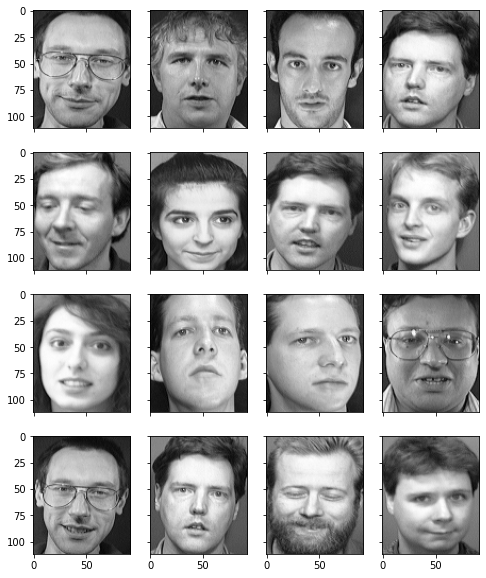

In [4]:
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceimages = random.sample(list(faces.values()), 16)
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
plt.show()

##### 2. Face image size, number of images, number of classes 

In [5]:
classes = set(filename.split('/')[0] for filename in faces.keys())

print("Face image size - ", list(faces.values())[0].shape)
print("Number of images - ", len(faces))
print("Number of classes - ", len(classes))

Face image size -  (112, 92)
Number of images -  400
Number of classes -  40


### Part 2 -  Train Test Split 

##### Created training and testing sets with 1-9 images from each folder for training and the last image for testing. Also flattened the images

In [6]:
facematrix = []
facelabel = []
for key,val in faces.items():
    if key.startswith("s40/"):
        continue # this is our test set
    if key == "s39/10.pgm":
        continue # this is our test set
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])

In [7]:
training_img = []
training_label = []
testing_img = []
testing_label = []

for key,val in faces.items():
    for x in range (40):
        if key == ('s' + str(x+1) + '/10.pgm'):
            testing_img.append(val)
            testing_label.append(key.split('/')[0])
    
for key,val in faces.items():
    for x in range(40):
        for y in range(8):
            if key.startswith('s' + str(x+1) + '/' + str(y+1)):
                training_img.append(val.flatten())
                training_label.append(key.split('/')[0])
        

##### Number of images in training and testing 

In [8]:
len(training_img)

360

In [9]:
len(testing_img)

40

### Part 3 - Apply PCA to Get Eigenfaces

In [10]:
facematrix = np.array(facematrix)

##### 1. Applying PCA on the training set

In [11]:
pca = PCA().fit(training_img)

##### 2. First 20 principal components 

In [12]:
pri_components = 20
eigenfaces = pca.components_[:pri_components]

##### 3. Visualize first 16 eigenfaces

<function matplotlib.pyplot.show(close=None, block=None)>

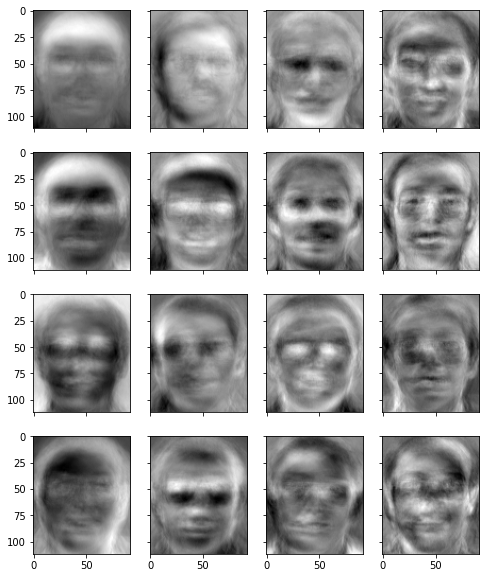

In [13]:
fig, axes = plt.subplots(4, 4, sharex = True, sharey = True, figsize = (8, 10))
face_size = list(faces.values())[0].shape

for i in range(16):
    axes[i%4][i//4].imshow(eigenfaces[i].reshape(face_size), cmap = 'gray')
plt.show

### Part 4 - Face Recognition 

##### 1. Weights for training samples 

In [14]:
train_weights = np.matmul(eigenfaces, (training_img - pca.mean_).T)

##### 2. Weights for each test image

In [26]:
test_weights = []
for x in range(40):
    imgs = np.array(testing_img[x]).reshape(1, -1)
    w =  np.matmul(eigenfaces, (imgs - pca.mean_).T)
    test_weights.append(w)

##### 3. Min distance euclidean between test weight and all training sample weights 

In [45]:
#test_img = faces["s35/4.pgm"].reshape(1,-1)
#test_imgweight = np.matmul(eigenfaces, (test_img - pca.mean_).T)
test_w = random.choice(test_weights)
euclidean_dist = np.linalg.norm(train_weights - test_w, axis = 0)

In [46]:
minimum = np.argmin(euclidean_dist)
print("Best match %s with Euclidean distance %f" % (training_label[minimum], euclidean_dist[minimum]))

Best match s10 with Euclidean distance 0.000000


##### 4

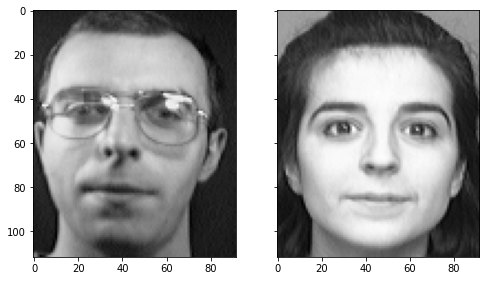

In [47]:
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(testing_img[minimum].reshape(face_size), cmap='gray')
axes[1].imshow(training_img[minimum].reshape(face_size), cmap='gray')
plt.show()

##### 5. Accuracy, total explained variance ratio

In [48]:
pred = minimum
actual = int(re.search(r'\d+', training_label[minimum]).group())

In [49]:
def find_accuracy(pred, actual, total):
    correct = 0
    wrong = 0
    total += 1
    if pred == actual:
        correct += 1
    else:
        wrong += 1
    return (correct, wrong, total)


In [50]:
correct, wrong, total = find_accuracy(pred, actual, total = 0)

corr_pred = round(correct/total, 3)
wrong_pred =  round(wrong/total,3)
Accuracy = round((correct*100)/total,3)

In [51]:
Accuracy

100.0

In [52]:
a = pca.explained_variance_ratio_.cumsum()
print('Total Explained Variance:', a.sum())

Total Explained Variance: 328.700283322984


### Part 5 - Face Recognition

##### 1. Using only first 2 principal components

In [53]:
pri_components = 2
eigenfaces_new = pca.components_[:pri_components]

<function matplotlib.pyplot.show(close=None, block=None)>

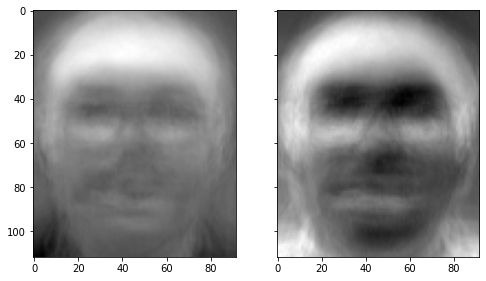

In [54]:
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (8, 10))
face_size = list(faces.values())[0].shape

axes[0].imshow(eigenfaces_new[0].reshape(face_size), cmap = 'gray')
axes[1].imshow(eigenfaces_new[1].reshape(face_size), cmap = 'gray')
plt.show

In [55]:
train_weights = np.matmul(eigenfaces_new, (training_img - pca.mean_).T)

In [56]:
test_weights = []
for x in range(40):
    imgs = np.array(testing_img[x]).reshape(1, -1)
    w =  np.matmul(eigenfaces_new, (imgs - pca.mean_).T)
    test_weights.append(w)

In [57]:
test_w = random.choice(test_weights)
euclidean_dist_new = np.linalg.norm(train_weights - test_w, axis = 0)

In [58]:
minimum_new = np.argmin(euclidean_dist_new)
print("Best match %s with Euclidean distance %f" % (training_label[minimum_new], euclidean_dist_new[minimum_new]))

Best match s34 with Euclidean distance 0.000000


##### Accuracy and Total Explained Variance 

In [59]:
pred_new = minimum_new
actual_new = int(re.search(r'\d+', training_label[minimum_new]).group())

In [60]:
correct, wrong, total = find_accuracy(pred_new, actual_new, total = 0)

corr_pred = round(correct/total, 3)
wrong_pred =  round(wrong/total,3)
Accuracy = round((correct*100)/total,3)

In [61]:
a = pca.explained_variance_ratio_
b= pca.explained_variance_ratio_.cumsum()
print('Total Explained Variance:', b.sum())

Total Explained Variance: 328.700283322984


##### Compare total explained variance ratio

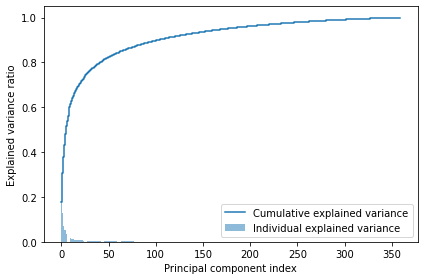

In [62]:
plt.bar(range(0,len(a)), a, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(b)), b, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()